In [1]:
import numpy as np
import scipy.signal as signal
%matplotlib notebook
import matplotlib.pyplot as plt

In [45]:
C_1 = 4.7e-9
C_2 = 56e-12
C_3 = 4.7e-6
R_1 = 10000
R_2 = 2400
R_3 = 1000
R_p = 5 # 0 - 50k

<IPython.core.display.Javascript object>


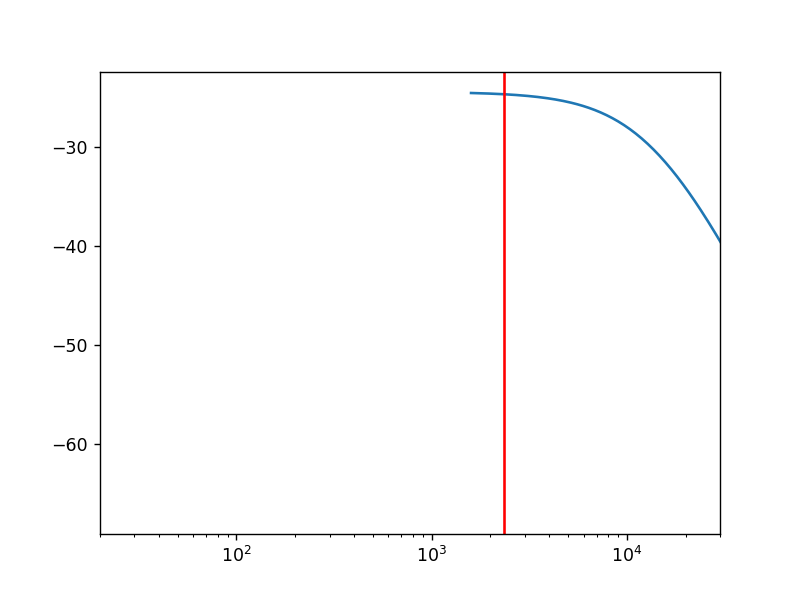

2354.1566021237722


In [46]:
R_1p = R_1 + R_p

a2 = R_1p**2 * C_1**2 * R_2 * C_3
a1 = 4 * R_1p * C_1 * R_2 * (R_3 * C_2 + 2 * C_3)
a0 = 4 * R_1p * C_1 * R_3

b2 = 0
b1 = 0
b0 = R_2 * C_3

w, H = signal.freqs ([b2, b1, b0], [a2, a1, a0])
plt.figure()
plt.semilogx (w / (2 * np.pi), 20 * np.log10 (np.abs (H)))
plt.xlim ((20, 30000))

det = a1**2 - 4*a0*a2
pole = np.sqrt (np.abs (det)) / (2 * a2)
freq = pole / (2 * np.pi)
print (freq)
plt.axvline (freq, color='r')